In [1]:
import warnings; warnings.simplefilter('ignore')

import re
import copy
import string
import timeit
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
# Number of examples
N = 5000
# Length of a feature
d = 128

In [3]:
def l2i(a):
        return int(ord(a)-ord('a'))
def i2l(i):
    if i >= 0:
        return chr(i+ord('a'))
    else:
        return '_'
def iors(s):
    try:
        return int(s)
    except ValueError: # if it is a string, return a string
        return s

In [4]:
def read_OCR(filename, n_features):
    F = open(filename)
    dataset = {}
    dataset['ids'] = []#np.zeros(n_examples, dtype=int)
    dataset['labels'] = []#np.zeros(n_examples,dtype=int)
    dataset['labelDic'] = {} # To profile the distribution of labels
    dataset['next_ids'] = []#np.zeros(n_examples,dtype=int)
    dataset['word_ids'] = []#np.zeros(n_examples,dtype=int)
    dataset['positions'] = []#np.zeros(n_examples,dtype=int)
    dataset['folds'] = []#np.zeros(n_examples,dtype=int)
    dataset['features'] = []#np.zeros([n_examples,n_features])
    
    for str_line in F.readlines():
        #line0 = map(iors, filter(None, re.split('\t', str_line.strip())))
        ## ATTENTION: If you are using Python3, use the following line instead
        line0 = list(map(iors, filter(None, re.split('\t', str_line.strip()))))


        dataset['ids'].append(int(line0.pop(0)))
        dataset['labels'].append(l2i(line0.pop(0))) # The label is converted into integer('a'=>0, 'z'=>25)
        if dataset['labels'][-1] in dataset['labelDic']:
            dataset['labelDic'][dataset['labels'][-1]] += 1
        else:
            dataset['labelDic'][dataset['labels'][-1]] = 1
            
        dataset['next_ids'].append(int(line0.pop(0)))
        dataset['word_ids'].append(int(line0.pop(0)))
        dataset['positions'].append(int(line0.pop(0)))
        dataset['folds'].append(int(line0.pop(0)))
        if len(line0) != 128:  # Sanity check of the length
            print (len(line0))
        dataset['features'].append(line0)

    return dataset

In [5]:
def format(dataset, N, L):
    # Group by words
    words = defaultdict(lambda: {'features': [], 'labels': []})
    for i in range(len(dataset['features'])):
        word_id = dataset['word_ids'][i]
        feats = dataset['features'][i]
        label = dataset['labels'][i]
        words[word_id]['features'].append(feats)
        words[word_id]['labels'].append(label)
        
    all_X = []
    all_y = []
    word_pos_info = []

    word_ids = list(words.keys())

    for wid in word_ids:
        feats = words[wid]['features']
        labels = words[wid]['labels']
        length = len(feats)
        
        if length < L:
            continue

        for i in range(length):
            feature_dict = {f"f_{j}": val for j, val in enumerate(feats[i])}
            all_X.append(feature_dict)
            all_y.append(labels[i])
            word_pos_info.append((wid, i))

    # Randomly sample N sequences
    combined = list(zip(all_X, all_y, word_pos_info))
    random.shuffle(combined)
    combined = combined[:N]
    X, y, word_pos_info = zip(*combined)

    return list(X), list(y), list(word_pos_info)

In [6]:
def train_auto_context(model, X_train, y_train, num_iterations, L, save_path):
    vec = DictVectorizer(sparse=False)
    X_train_vec = vec.fit_transform(X_train)

    if num_iterations == 1:
        train_start = timeit.default_timer()
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_train_vec)
        train_end = timeit.default_timer()
        print(f"Training time elapsed: {train_end - train_start:.2f} s")
        train_acc = accuracy_score(y_train, y_pred)
        print(f"Training accuracy: {train_acc:.4f}")
        with open(save_path, 'wb') as f:
            pickle.dump((model, vec), f)
        return model, vec


    # Training the model
    train_start = timeit.default_timer()
    for step in range(num_iterations):
        model.fit(X_train_vec, y_train)

        probs = model.predict_proba(X_train_vec)
        num_classes = len(probs[0])

        new_X_train = []
        for i in range(len(X_train)):
            feat = dict(X_train[i])
            for offset in range(-(L // 2), L // 2 + 1):
                if offset == 0:
                    continue
                pos = i + offset
                if 0 <= pos < len(probs):
                    for k in range(num_classes):
                        feat[f"context_{offset:+}_{k}"] = probs[pos][k]
            new_X_train.append(feat)
        X_train_vec = vec.fit_transform(new_X_train)
    train_end = timeit.default_timer()
    y_pred = model.predict(X_train_vec)
    print(f"Training time elapsed: {train_end - train_start:.2f} s")
    train_acc = accuracy_score(y_train, y_pred)
    print(f"Training accuracy: {train_acc:.4f}")

    with open(save_path, 'wb') as f:
        pickle.dump((model, vec), f)
    
    return model, vec

In [7]:
def test_auto_context(model, X_test, y_test, id_test, num_iterations, L, load_path):
    with open(load_path, 'rb') as f:
        model, vec = pickle.load(f)
    
    X_vec = vec.transform(X_test)

    if num_iterations == 1:
        start_test = timeit.default_timer()
        y_pred = model.predict(X_vec)
        end_test = timeit.default_timer()
        print(f"Testing time elapsed: {end_test - start_test:.2f} s")
        test_acc = accuracy_score(y_test, y_pred)
        print(f"Testing accuracy: {test_acc:.4f}")

        # Full word accuracy
        start_pred = timeit.default_timer()
        word_truth, word_pred = {}, {}
        for pred, true, (wid, pos) in zip(y_pred, y_test, id_test):
            word_truth.setdefault(wid, {})[pos] = true
            word_pred.setdefault(wid, {})[pos] = pred
        correct_words = sum(pw == tw for pw, tw in zip(word_pred.values(), word_truth.values()))
        total_words = len(word_truth)
        word_acc = correct_words / total_words if total_words > 0 else 0.0
        end_pred = timeit.default_timer()
        print(f"Word accuracy: {word_acc:.4f} ({correct_words}/{total_words})")
        return y_pred

    start_test = timeit.default_timer()
    for step in range(num_iterations):
        probs = model.predict_proba(X_vec)
        num_classes = len(probs[0])

        new_X_test = []
        for i in range(len(X_test)):
            feat = dict(X_test[i])
            for offset in range(-(L // 2), L // 2 + 1):
                if offset == 0:
                    continue
                pos = i + offset
                if 0 <= pos < len(probs):
                    for k in range(num_classes):
                        feat[f"context_{offset:+}_{k}"] = probs[pos][k]
            new_X_test.append(feat)
        X_test_vec = vec.transform(new_X_test)
    end_test = timeit.default_timer()

    y_pred = model.predict(X_test_vec)
    print(f"Testing time elapsed: {end_test - start_test:.2f} s")
    test_acc = accuracy_score(y_test, model.predict(X_test_vec))
    print(f"Testing accuracy: {test_acc:.4f}")

    # Full word accuracy
    start_pred = timeit.default_timer()
    word_truth, word_pred = {}, {}
    for pred, true, (wid, pos) in zip(y_pred, y_test, id_test):
        word_truth.setdefault(wid, {})[pos] = true
        word_pred.setdefault(wid, {})[pos] = pred
    
    correct_words = sum(pw == tw for pw, tw in zip(word_pred.values(), word_truth.values()))
    total_words = len(word_truth)
    word_acc = correct_words / total_words if total_words > 0 else 0.0
    end_pred = timeit.default_timer()
    print(f"Prediction time elapsed: {end_pred - start_pred:.2f} s")
    print(f"Word accuracy: {word_acc:.4f} ({correct_words}/{total_words})")
    return y_pred

In [8]:
def showFeatures(features, true_labels, predicted_labels, num=20):
    plt.figure(figsize=(num, 4))

    for i in range(num):
        npfeature = np.array(features[i])
        image = npfeature.reshape(16, 8)

        true_char = i2l(true_labels[i])
        pred_char = i2l(predicted_labels[i])

        plt.subplot(1, num, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"T:{true_char}\nP:{pred_char}", fontsize=8)
        plt.axis('off')

    plt.suptitle("Character Predictions — T: Truth, P: Predicted", fontsize=12)
    plt.tight_layout()
    plt.show()

In [9]:
dataset = read_OCR('OCRdataset/letter.data', d)

In [10]:
wordid_to_indices = defaultdict(list)
for idx, wid in enumerate(dataset['word_ids']):
    wordid_to_indices[wid].append(idx)

# N_ITERATIONS = 1

In [11]:
n_iter = 1

## L = 1

In [12]:
L = 1

### 4000/1000

In [13]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.8
model_path = 'ac1_1_82.obj'

In [14]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [15]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 0.24 s
Training accuracy: 0.8628


Testing time elapsed: 0.00 s
Testing accuracy: 0.7280
Word accuracy: 0.7117 (659/926)


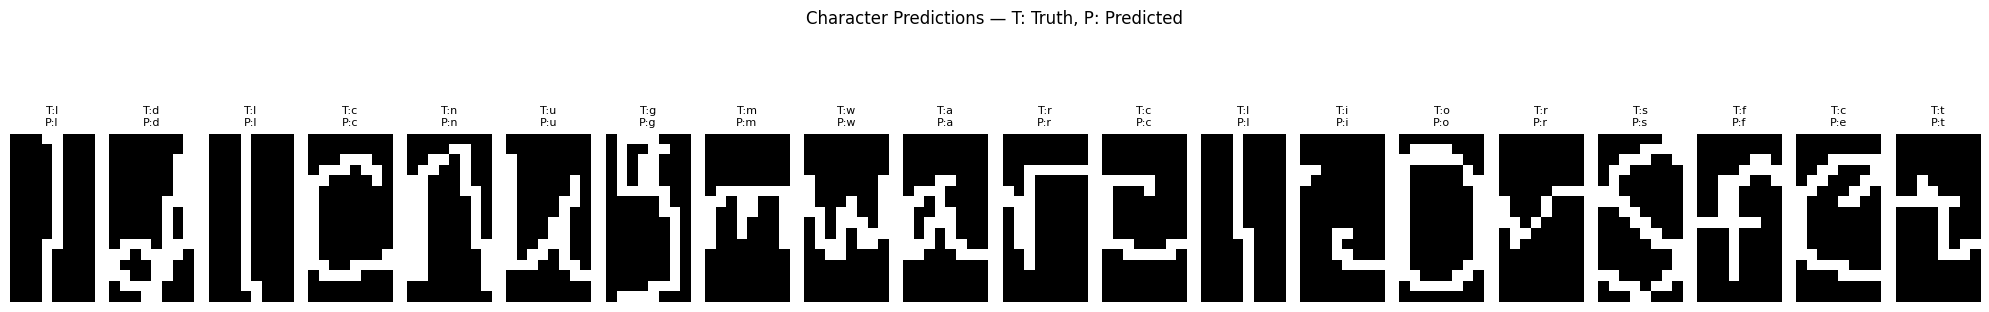

In [16]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 2500/2500

In [17]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.5
model_path = 'ac1_1_55.obj'

In [18]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [19]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 0.13 s
Training accuracy: 0.8956


Testing time elapsed: 0.00 s
Testing accuracy: 0.6852
Word accuracy: 0.6439 (1338/2078)


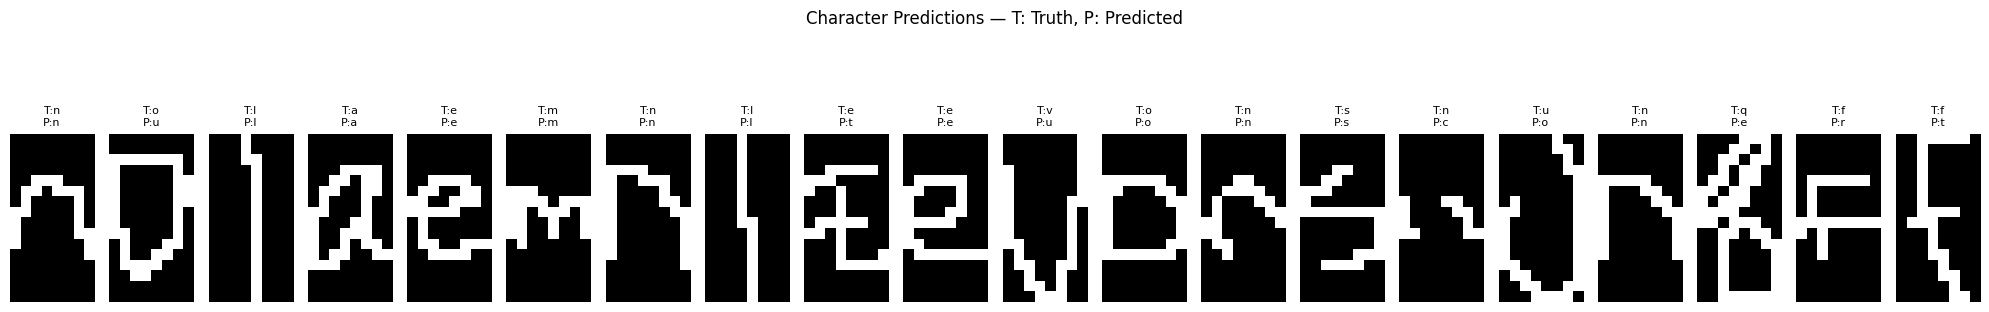

In [20]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 1000/4000

In [21]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.2
model_path = 'ac1_1_28.obj'

In [22]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [23]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 0.06 s
Training accuracy: 0.9620


Testing time elapsed: 0.00 s
Testing accuracy: 0.6535
Word accuracy: 0.5892 (1777/3016)


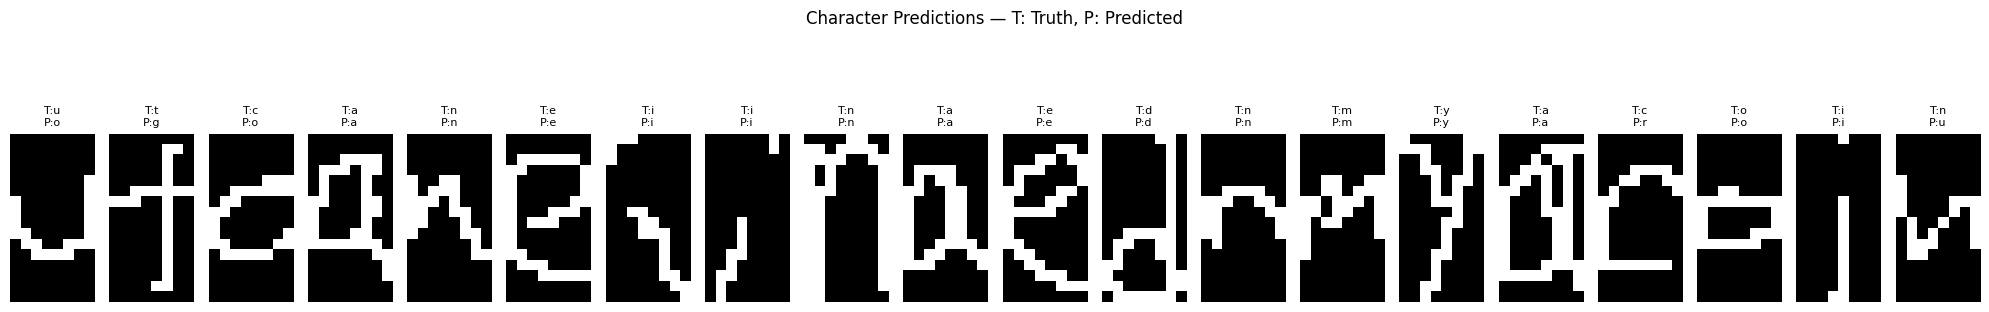

In [24]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

## L = 2

In [25]:
L = 2

### 4000/1000

In [26]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.8
model_path = 'ac1_2_82.obj'

In [27]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [28]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 0.24 s
Training accuracy: 0.8695


Testing time elapsed: 0.00 s
Testing accuracy: 0.7150
Word accuracy: 0.7099 (668/941)


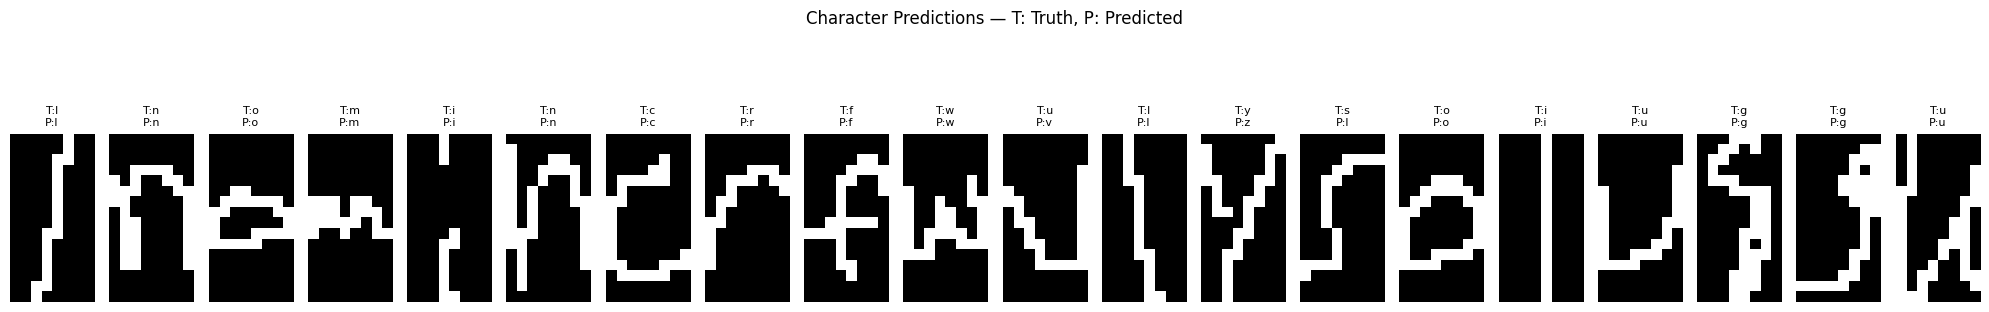

In [29]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 2500/2500

In [30]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.5
model_path = 'ac1_2_55.obj'

In [31]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [32]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 0.13 s
Training accuracy: 0.9072


Testing time elapsed: 0.00 s
Testing accuracy: 0.7080
Word accuracy: 0.6654 (1388/2086)


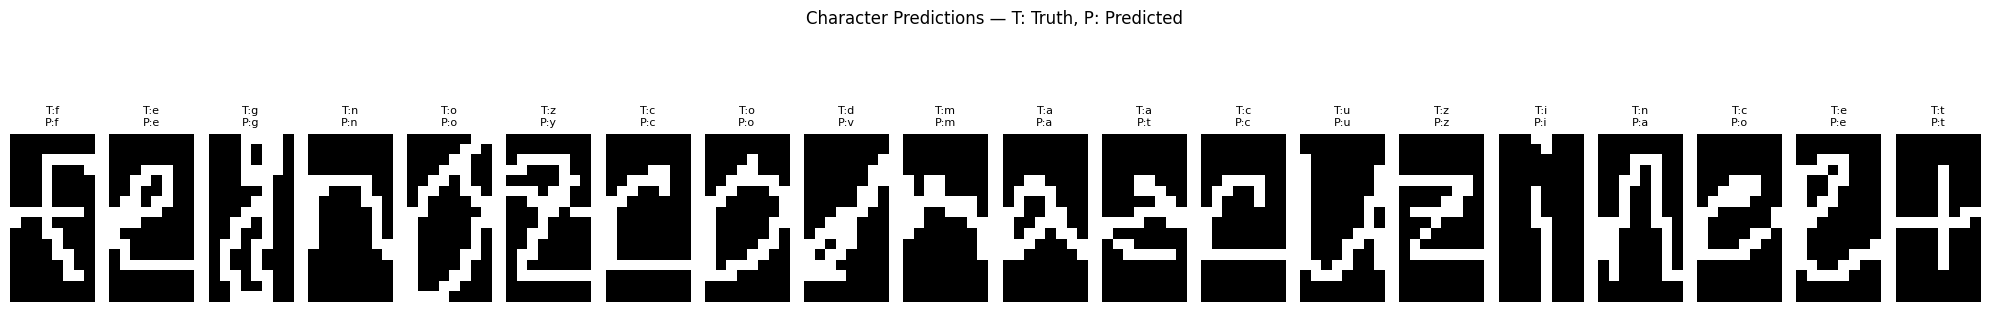

In [33]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 1000/4000

In [34]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.2
model_path = 'ac1_2_28.obj'

In [35]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [36]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 0.06 s
Training accuracy: 0.9620


Testing time elapsed: 0.00 s
Testing accuracy: 0.6430
Word accuracy: 0.5783 (1757/3038)


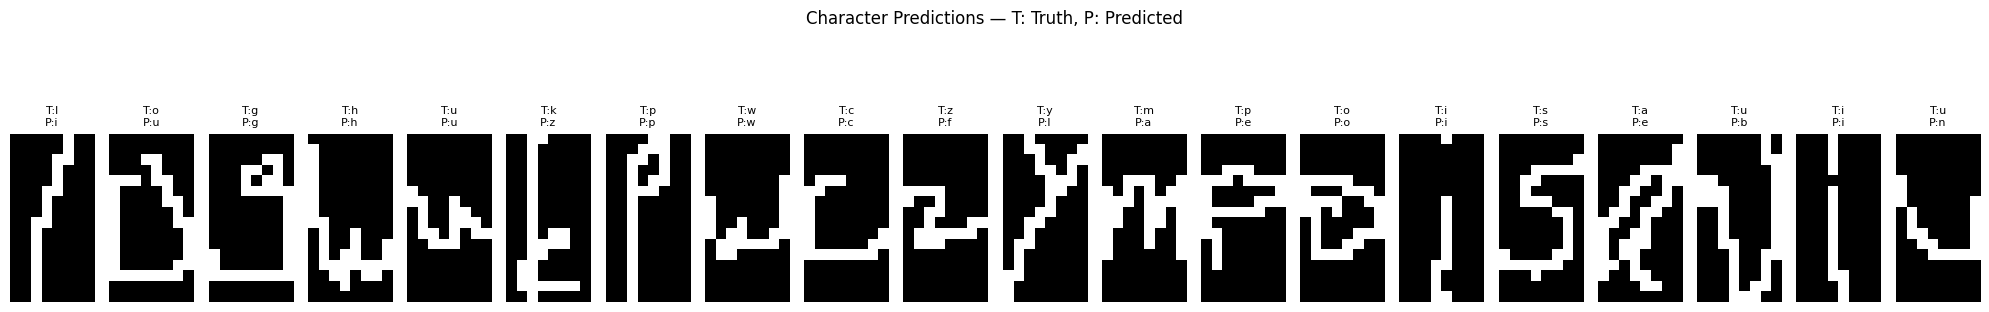

In [37]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

## L = 3

In [38]:
L = 3

### 4000/1000

In [39]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.8
model_path = 'ac1_3_82.obj'

In [40]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [41]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 0.23 s
Training accuracy: 0.8600


Testing time elapsed: 0.00 s
Testing accuracy: 0.7200
Word accuracy: 0.7101 (659/928)


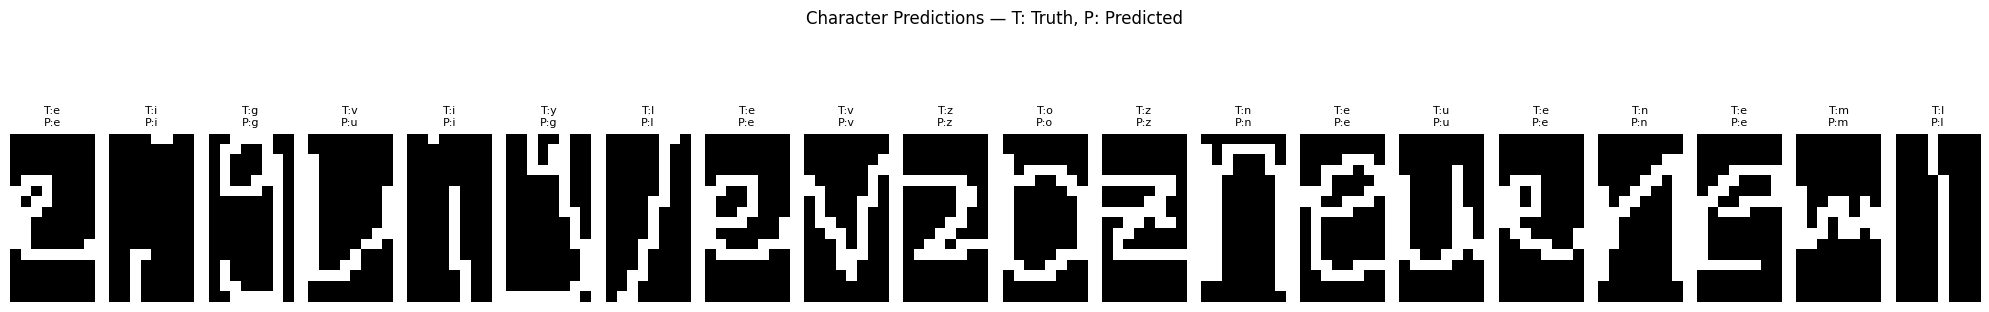

In [42]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 2500/2500

In [43]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.5
model_path = 'ac1_3_55.obj'

In [44]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [45]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 0.12 s
Training accuracy: 0.8960


Testing time elapsed: 0.00 s
Testing accuracy: 0.6740
Word accuracy: 0.6302 (1302/2066)


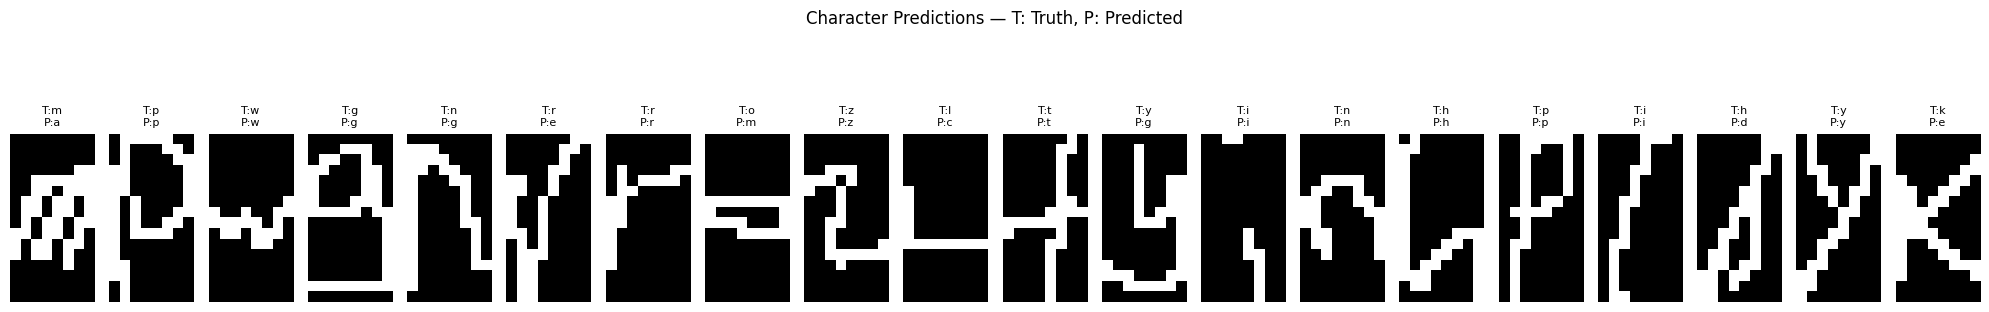

In [46]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 1000/4000

In [47]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.2
model_path = 'ac1_3_28.obj'

In [48]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [49]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 0.06 s
Training accuracy: 0.9670


Testing time elapsed: 0.00 s
Testing accuracy: 0.6240
Word accuracy: 0.5600 (1670/2982)


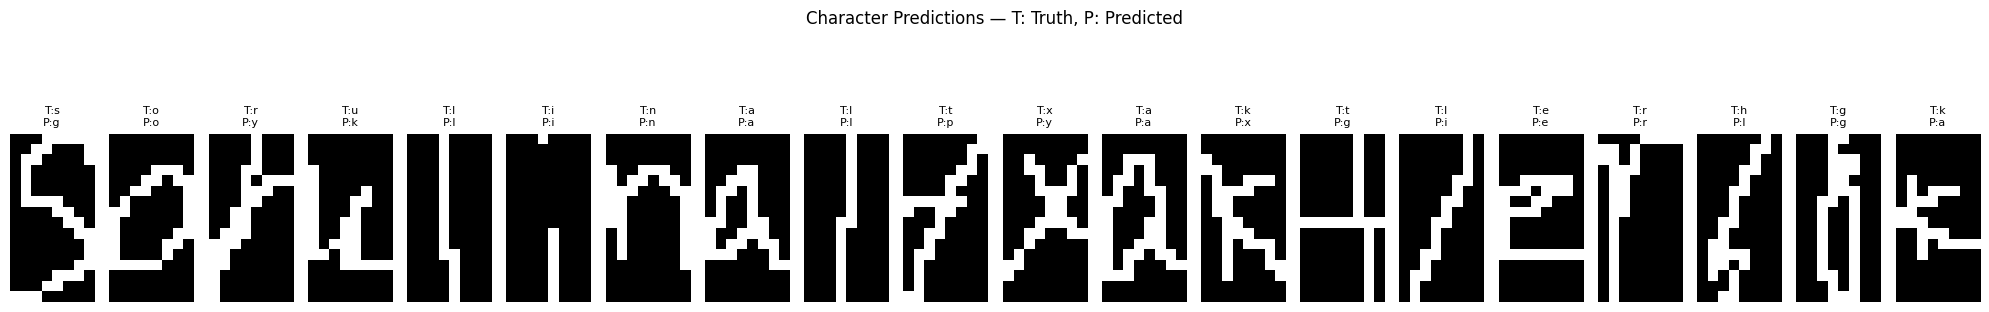

In [50]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

# N_ITERATIONS = 3

In [51]:
n_iter = 3

## L = 1

In [52]:
L = 1

### 4000/1000

In [53]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.8
model_path = 'ac3_1_82.obj'

In [54]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [55]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 1.15 s
Training accuracy: 0.8680


Testing time elapsed: 0.13 s
Testing accuracy: 0.7090
Prediction time elapsed: 0.00 s
Word accuracy: 0.6957 (647/930)


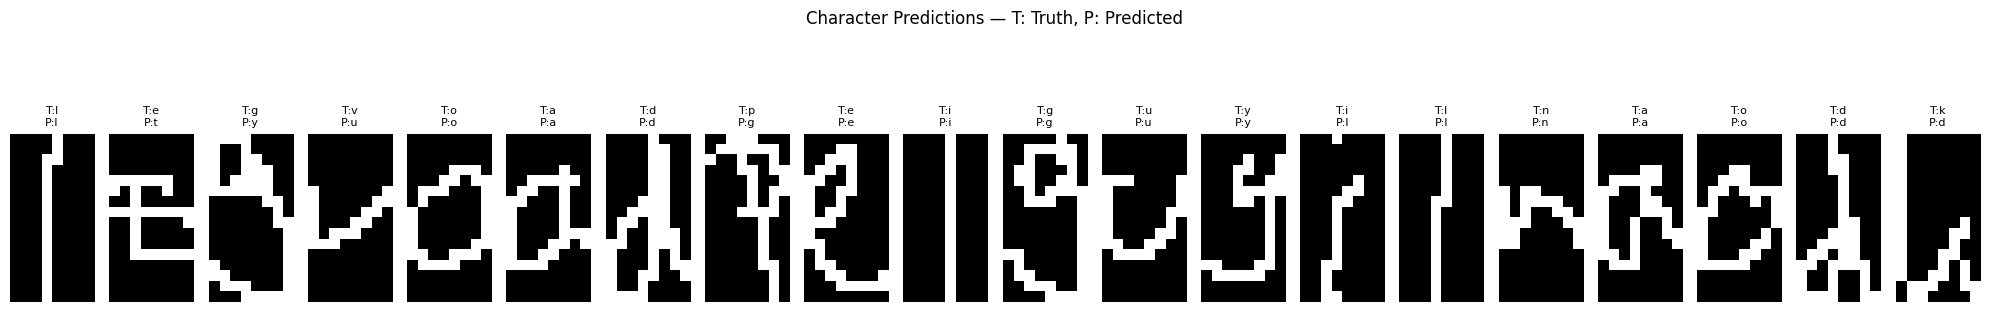

In [56]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 2500/2500

In [57]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.5
model_path = 'ac3_1_55.obj'

In [58]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [59]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 0.64 s
Training accuracy: 0.9024


Testing time elapsed: 0.27 s
Testing accuracy: 0.6796
Prediction time elapsed: 0.00 s
Word accuracy: 0.6405 (1336/2086)


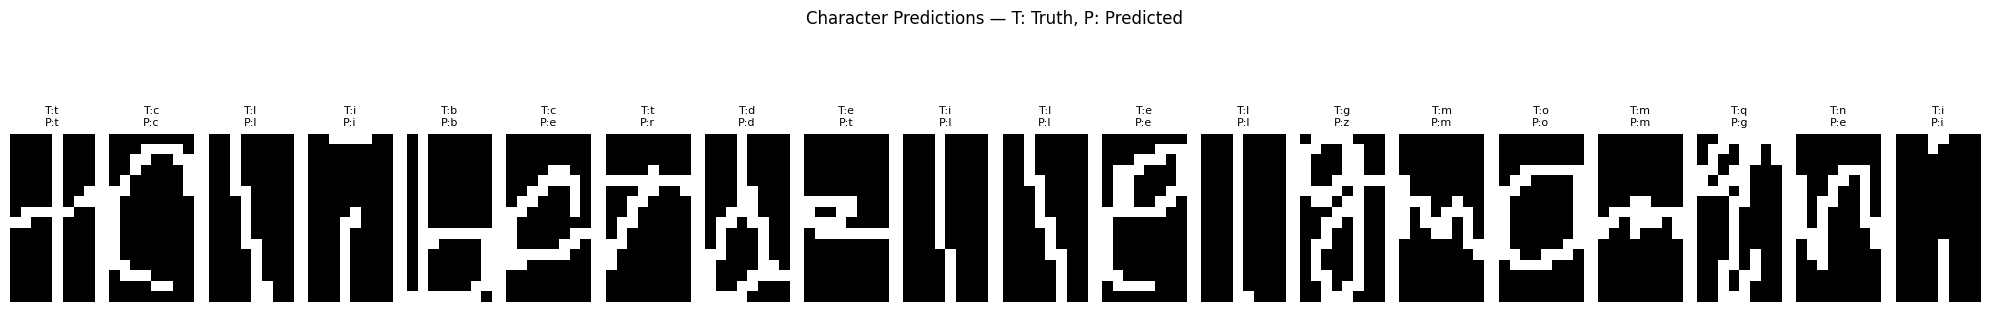

In [60]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 1000/4000

In [61]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.2
model_path = 'ac3_1_28.obj'

In [62]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [63]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 0.31 s
Training accuracy: 0.9720


Testing time elapsed: 0.45 s
Testing accuracy: 0.6315
Prediction time elapsed: 0.00 s
Word accuracy: 0.5609 (1695/3022)


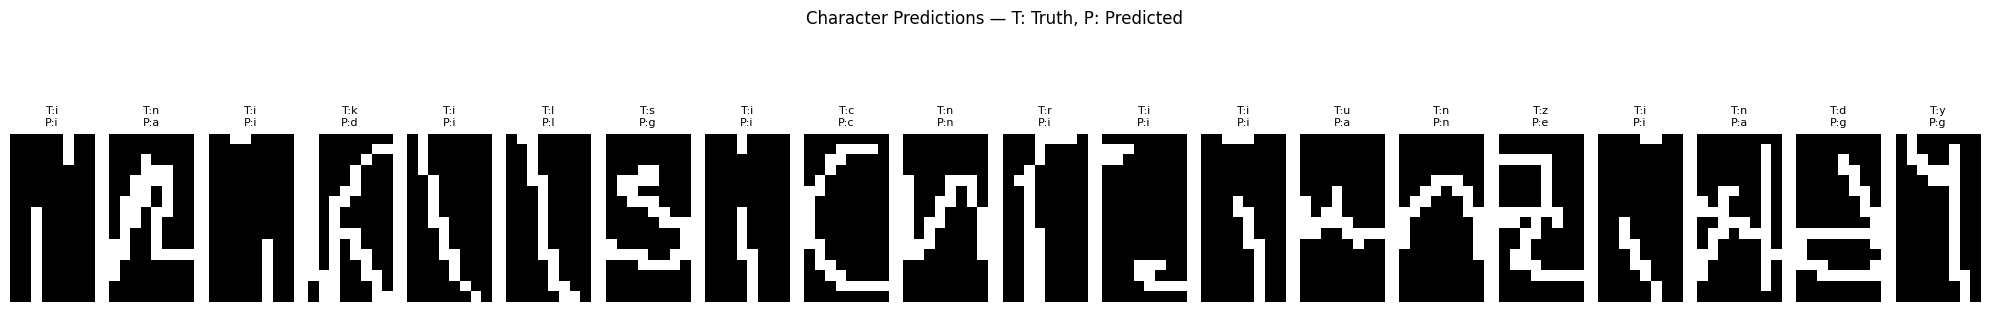

In [64]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

## L = 2

In [65]:
L = 2

### 4000/1000

In [66]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.8
model_path = 'ac3_2_82.obj'

In [67]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [68]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 1.85 s
Training accuracy: 0.8835


Testing time elapsed: 0.20 s
Testing accuracy: 0.7240
Prediction time elapsed: 0.01 s
Word accuracy: 0.7123 (661/928)


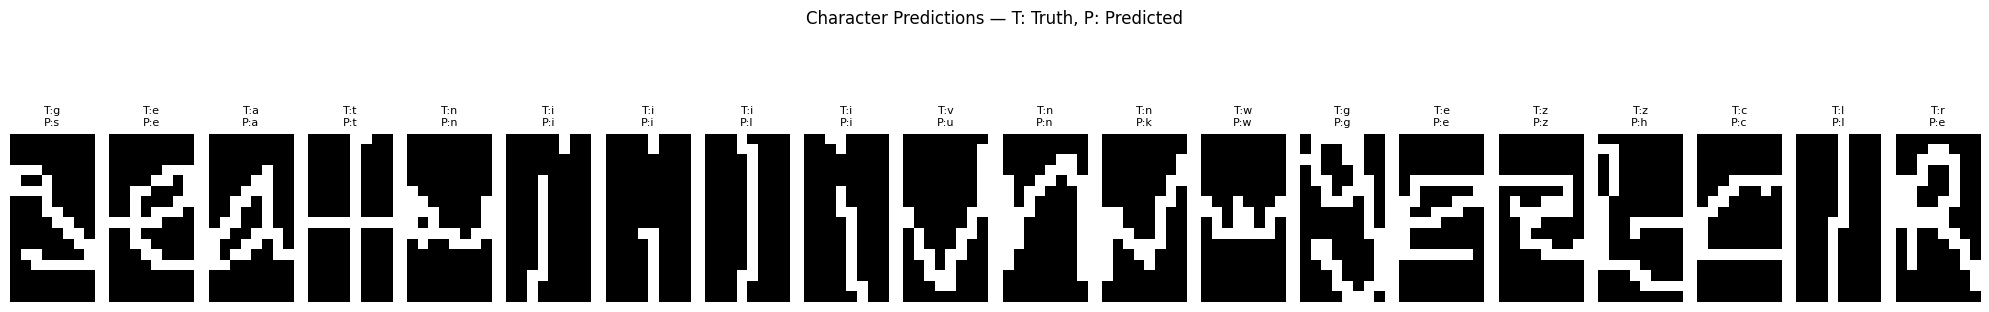

In [69]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 2500/2500

In [70]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.5
model_path = 'ac3_2_55.obj'

In [71]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [72]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 1.02 s
Training accuracy: 0.9216


Testing time elapsed: 0.49 s
Testing accuracy: 0.6856
Prediction time elapsed: 0.00 s
Word accuracy: 0.6492 (1360/2095)


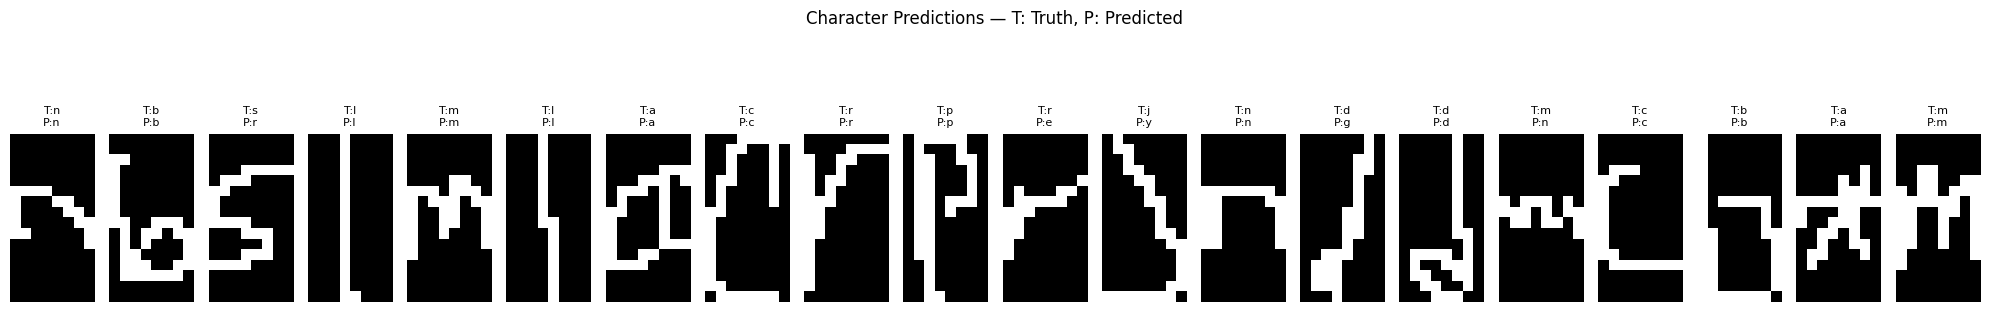

In [73]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 1000/4000

In [74]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.2
model_path = 'ac3_2_28.obj'

In [75]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [76]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 0.39 s
Training accuracy: 0.9820


Testing time elapsed: 0.80 s
Testing accuracy: 0.6295
Prediction time elapsed: 0.00 s
Word accuracy: 0.5598 (1685/3010)


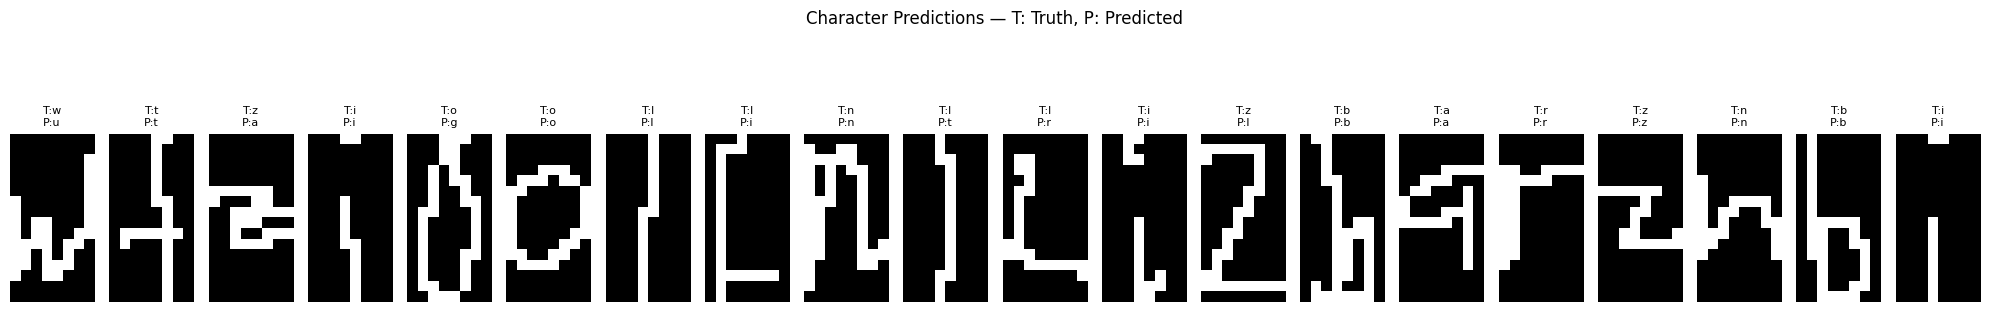

In [77]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

## L = 3

In [78]:
L = 3

### 4000/1000

In [79]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.8
model_path = 'ac3_3_82.obj'

In [80]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [81]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 1.69 s
Training accuracy: 0.8878


Testing time elapsed: 0.23 s
Testing accuracy: 0.7210
Prediction time elapsed: 0.01 s
Word accuracy: 0.7015 (637/908)


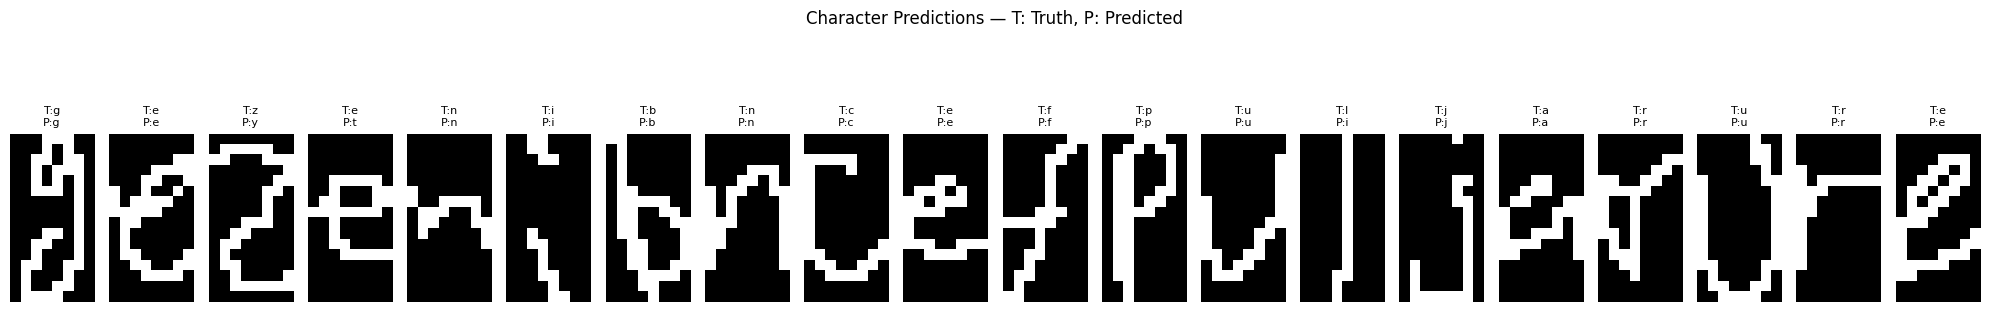

In [82]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 2500/2500

In [83]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.5
model_path = 'ac3_3_55.obj'

In [84]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [85]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 1.01 s
Training accuracy: 0.9192


Testing time elapsed: 0.52 s
Testing accuracy: 0.6852
Prediction time elapsed: 0.00 s
Word accuracy: 0.6443 (1337/2075)


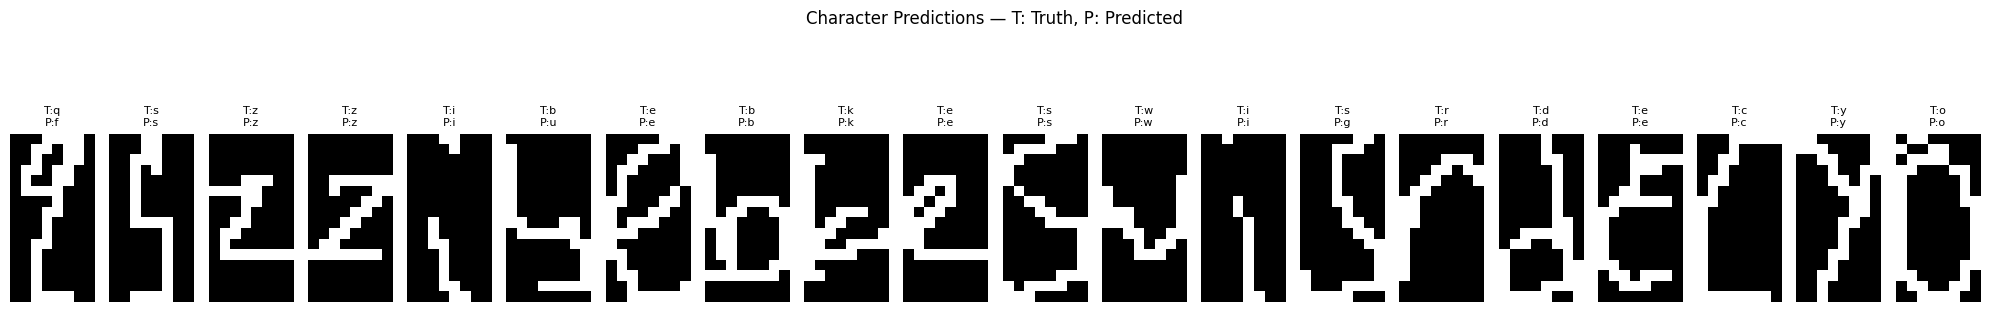

In [86]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 1000/4000

In [87]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.2
model_path = 'ac3_3_28.obj'

In [88]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [89]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 0.46 s
Training accuracy: 0.9710


Testing time elapsed: 0.80 s
Testing accuracy: 0.6418
Prediction time elapsed: 0.00 s
Word accuracy: 0.5797 (1763/3041)


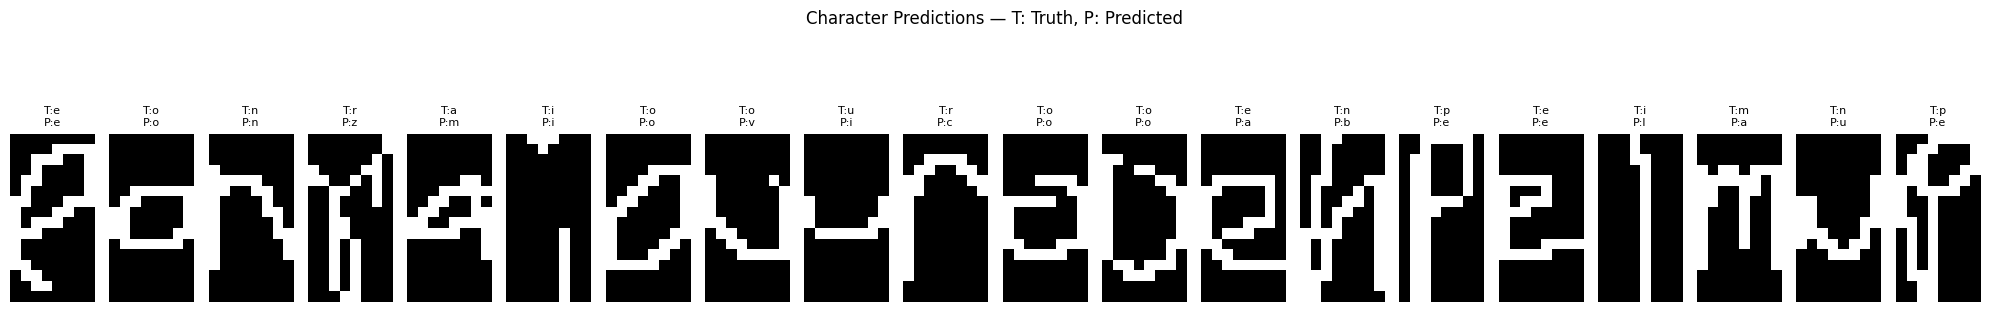

In [90]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

# N_ITERATIONS = 5

In [91]:
n_iter = 5

## L = 1

In [92]:
L = 1

### 4000/1000

In [93]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.8
model_path = 'ac5_1_82.obj'

In [94]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [95]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 2.31 s
Training accuracy: 0.8580


Testing time elapsed: 0.19 s
Testing accuracy: 0.7110
Prediction time elapsed: 0.00 s
Word accuracy: 0.6999 (653/933)


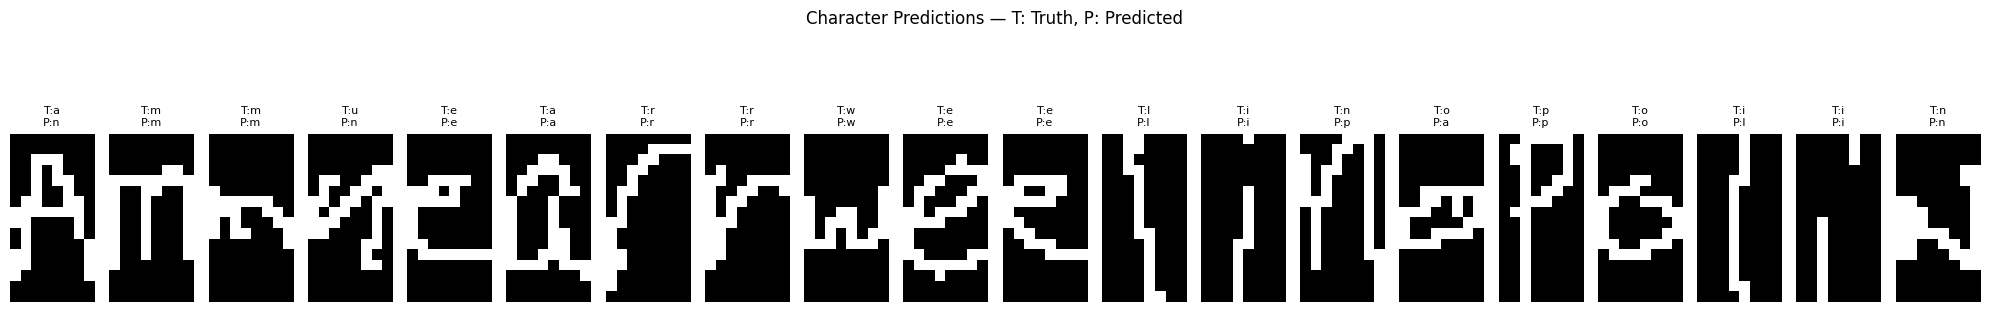

In [96]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 2500/2500

In [97]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.5
model_path = 'ac5_1_55.obj'

In [98]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [99]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 1.25 s
Training accuracy: 0.9072


Testing time elapsed: 0.46 s
Testing accuracy: 0.7132
Prediction time elapsed: 0.01 s
Word accuracy: 0.6773 (1404/2073)


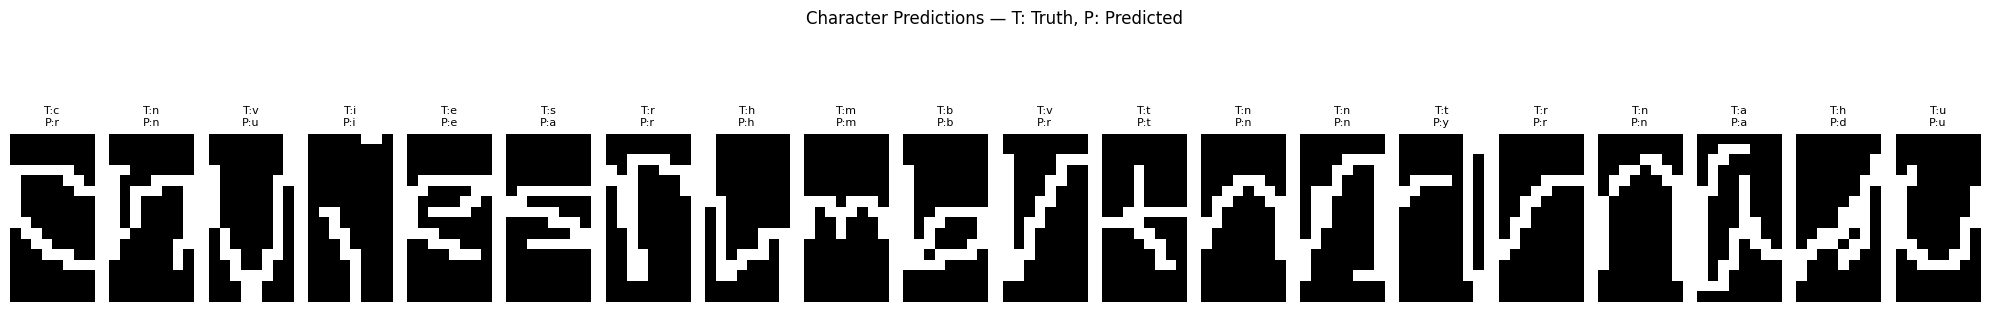

In [100]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 1000/4000

In [101]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.2
model_path = 'ac5_1_28.obj'

In [102]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [103]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 0.46 s
Training accuracy: 0.9640


Testing time elapsed: 0.75 s
Testing accuracy: 0.6583
Prediction time elapsed: 0.00 s
Word accuracy: 0.5951 (1786/3001)


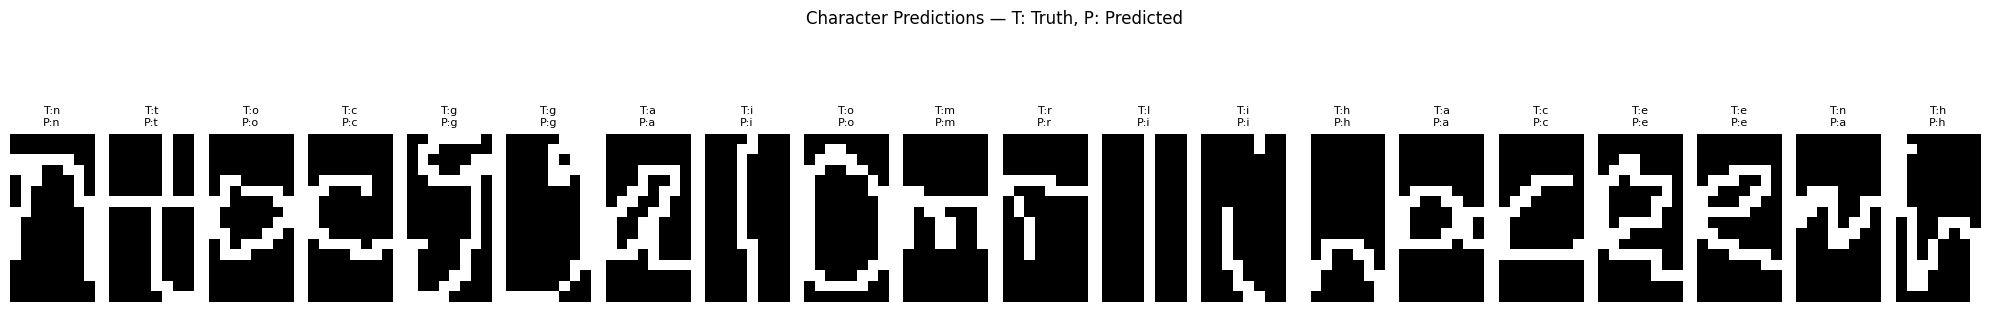

In [104]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

## L = 2

In [105]:
L = 2

### 4000/1000

In [106]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.8
model_path = 'ac5_2_82.obj'

In [107]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [108]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 2.93 s
Training accuracy: 0.9002


Testing time elapsed: 0.35 s
Testing accuracy: 0.7200
Prediction time elapsed: 0.00 s
Word accuracy: 0.7123 (671/942)


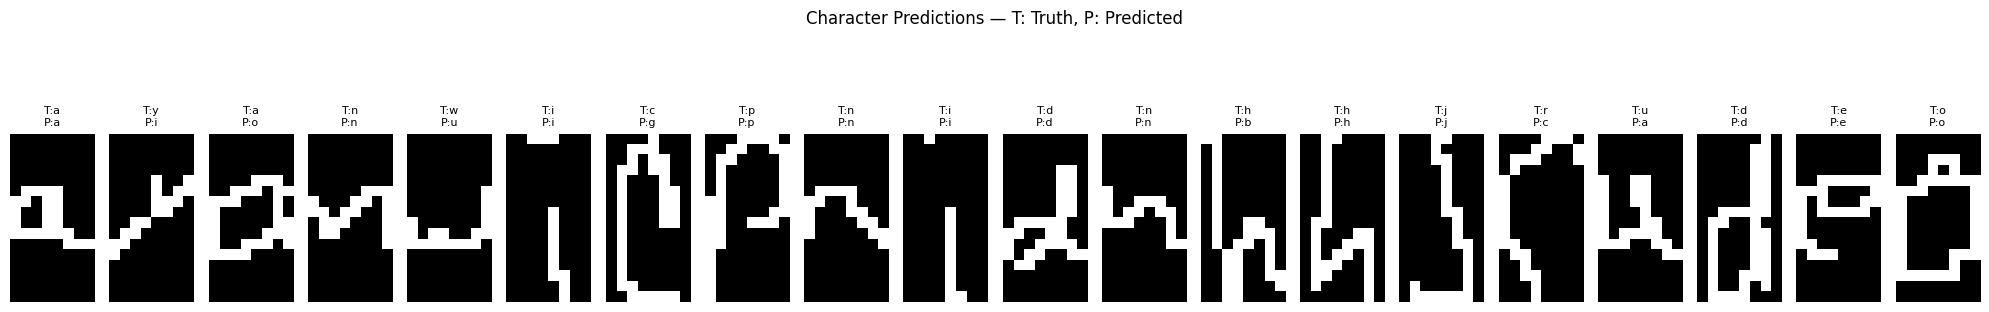

In [109]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 2500/2500

In [110]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.5
model_path = 'ac5_2_55.obj'

In [111]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [112]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 1.82 s
Training accuracy: 0.9236


Testing time elapsed: 0.85 s
Testing accuracy: 0.7064
Prediction time elapsed: 0.01 s
Word accuracy: 0.6736 (1416/2102)


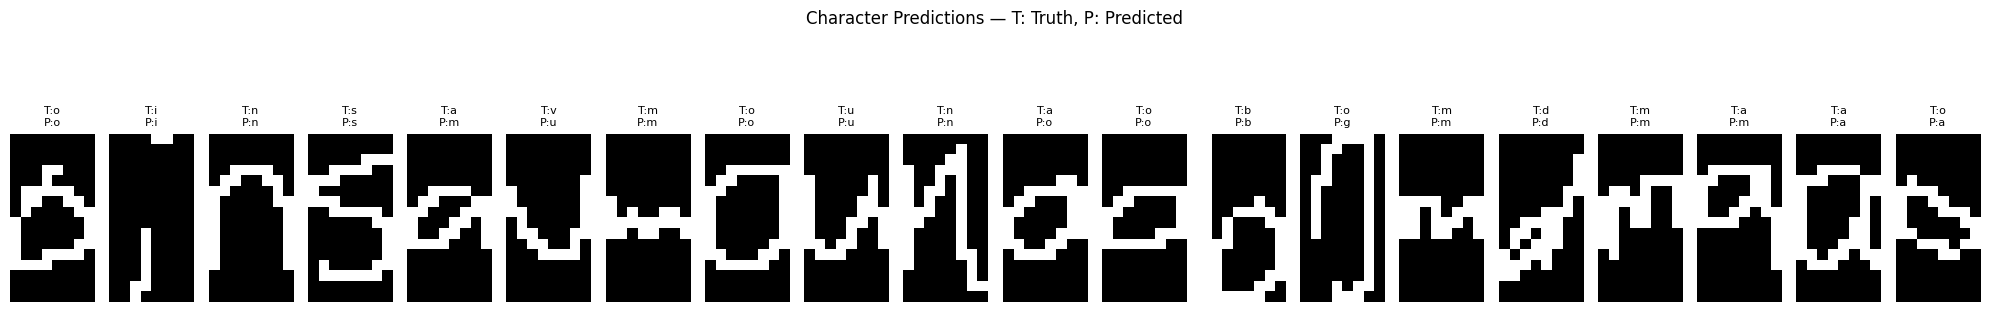

In [113]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 1000/4000

In [114]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.2
model_path = 'ac5_2_28.obj'

In [115]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [116]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 0.77 s
Training accuracy: 0.9870


Testing time elapsed: 1.36 s
Testing accuracy: 0.6432
Prediction time elapsed: 0.02 s
Word accuracy: 0.5766 (1716/2976)


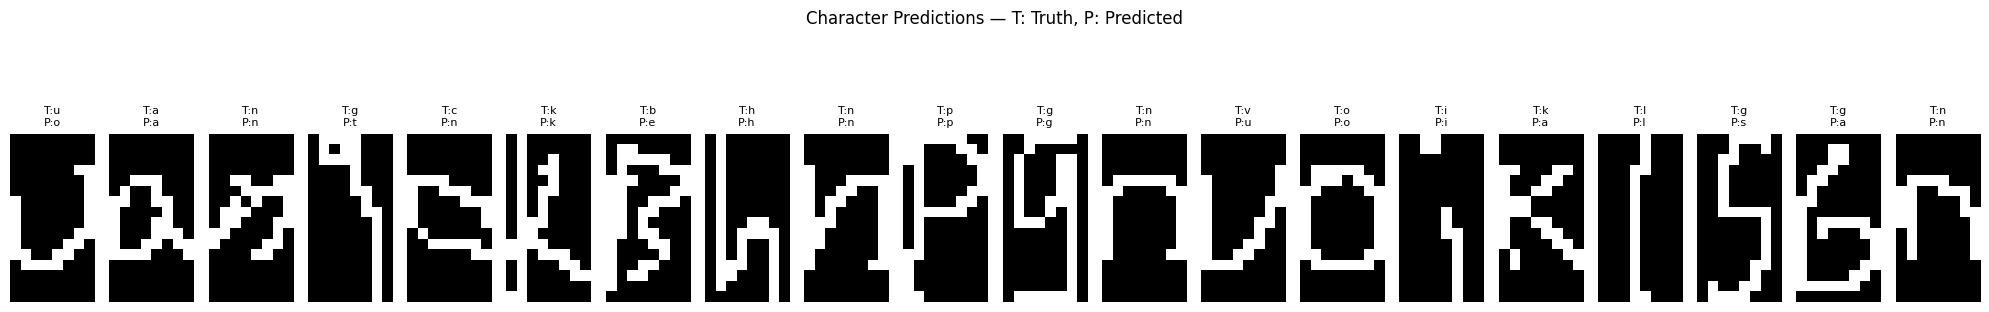

In [117]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

## L = 3

In [118]:
L = 3

### 4000/1000

In [119]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.8
model_path = 'ac5_3_82.obj'

In [120]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [121]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 2.76 s
Training accuracy: 0.8942


Testing time elapsed: 0.33 s
Testing accuracy: 0.7120
Prediction time elapsed: 0.00 s
Word accuracy: 0.7094 (659/929)


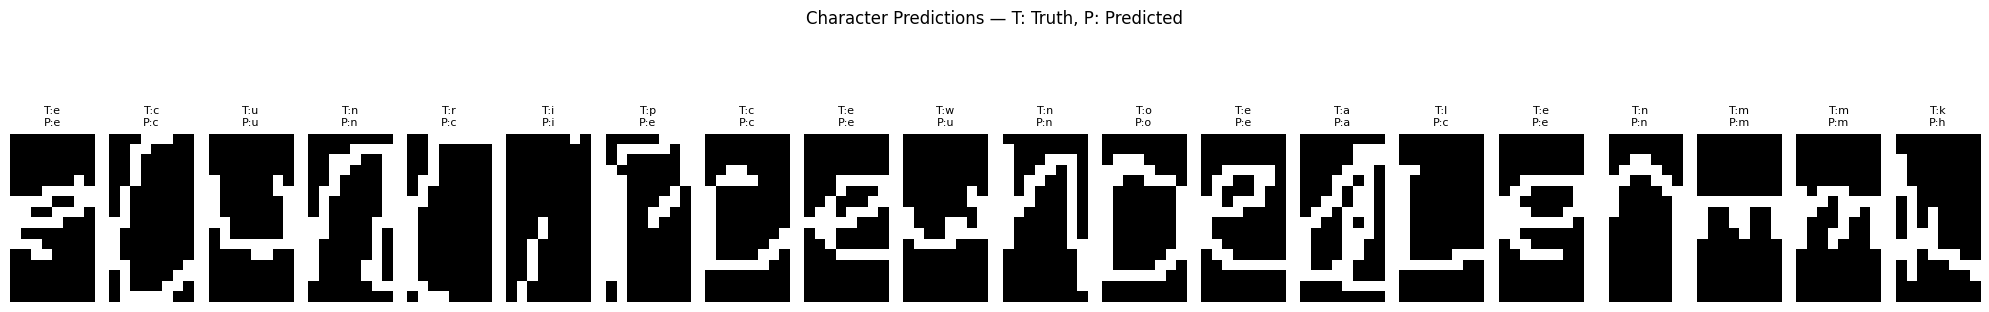

In [122]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 2500/2500

In [123]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.5
model_path = 'ac5_3_55.obj'

In [124]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [125]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 1.80 s
Training accuracy: 0.9224


Testing time elapsed: 0.84 s
Testing accuracy: 0.6912
Prediction time elapsed: 0.01 s
Word accuracy: 0.6577 (1370/2083)


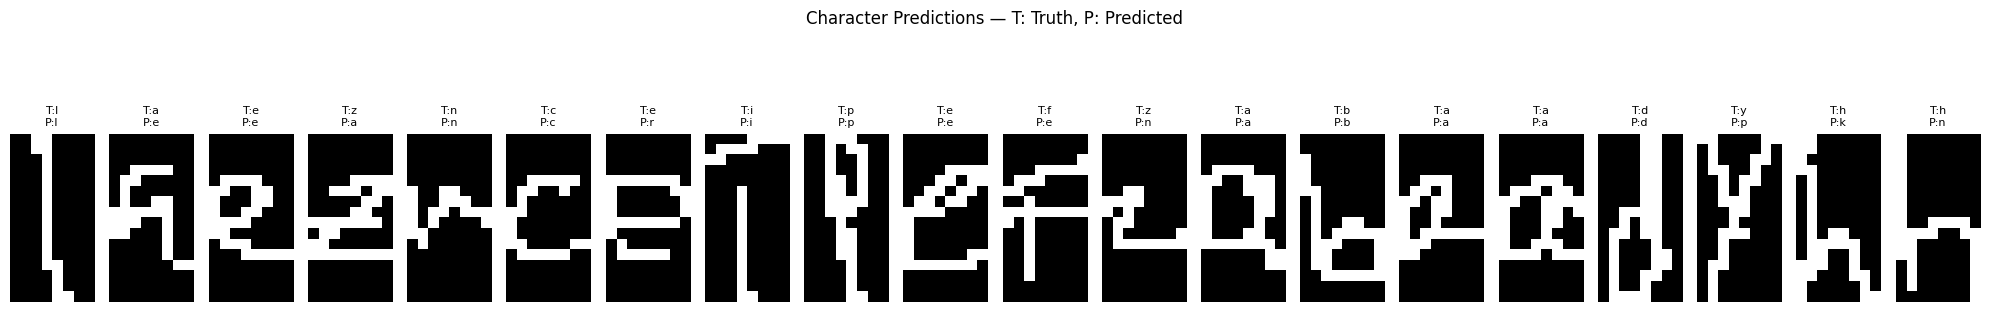

In [126]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)

### 1000/4000

In [127]:
features, labels, word_pos_info = format(dataset, N, L)
TRAIN = 0.2
model_path = 'ac5_3_28.obj'

In [128]:
X_train, X_test = features[:int(N * TRAIN)], features[int(N * TRAIN):]
y_train, y_test = labels[:int(N * TRAIN)], labels[int(N * TRAIN):]
id_train, id_test = word_pos_info[:int(N * TRAIN)], word_pos_info[int(N * TRAIN):]

In [129]:
lr = LogisticRegression(max_iter=200)

model, vec = train_auto_context(lr, X_train, y_train, n_iter, L, model_path)

Training time elapsed: 0.68 s
Training accuracy: 0.9830


Testing time elapsed: 1.39 s
Testing accuracy: 0.6320
Prediction time elapsed: 0.01 s
Word accuracy: 0.5659 (1670/2951)


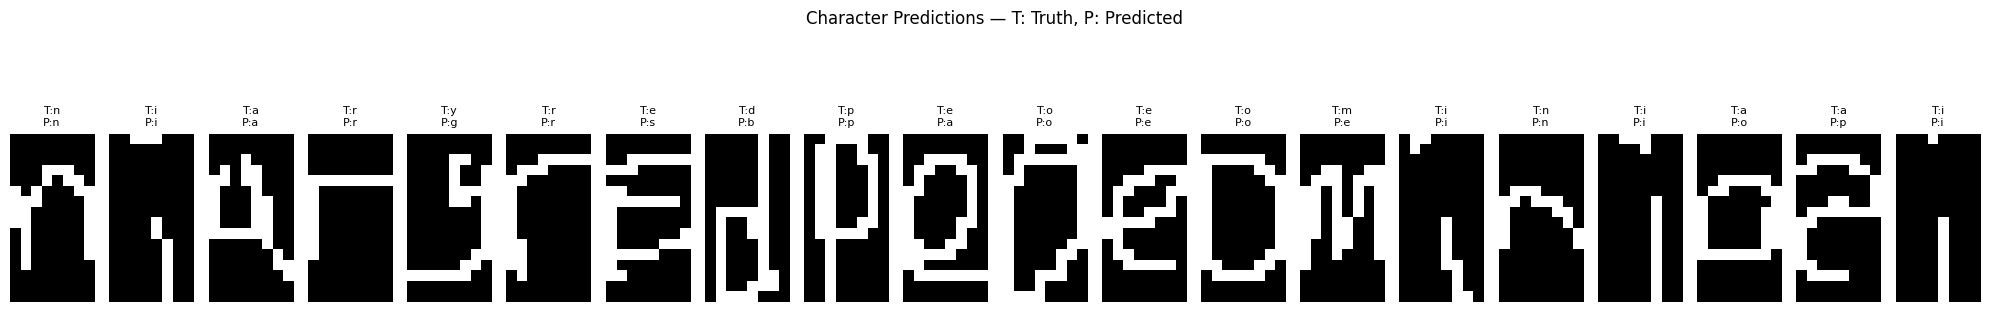

Bad pipe message: %s [b'V8\xa5\xae\xfd\xf8$\xc2\xb8\x8d\xc9\xc7\xe6\x95u\xb2\x14\xbe K\x1dc\x9e,\xc1;\x07Vg\xeeI0V\xa1\x85KE\x06u$\x17G\xf57\xfc\xda\xde\xafw\x81\xc8\x00 ::\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x06S\xba\xba\x00\x00\x00#\x00\x00\xfe\r\x00\xda\x00\x00\x01\x00\x01\x08\x00 \xb0\xd1+;\xeb\xabt\x96\xa75[\xee\xb8q3\x7f\x86#9\xb53[\xc1f\xe6d\xaf\t\xafH\xcd', b'\xb0H\x1b\xf5cZ\xe3\x8a']
Bad pipe message: %s [b'E\x88\x81\xb4~]J\x1ex:\x9b]\xbe\xd4$\x82\x90! P\x11y\xb0\x83uH\xfe\xa0\xc4O\x9a=\xf6e\x9d\x02n\xc6!\xaa\xcao\xe0\x86 \x02~%S\xa4.\x00 \xda\xda\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x06\x93zz\x00\x00D\xcd\x00\x05\x00\x03\x02h2\x00\n\x00\x0c\x00\njj\x11\xec\x00\x1d\x00\x17\x00\x18\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\x00+\x00\x07\x06JJ\x03\x04\x03\x03\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06

In [130]:
y_pred = test_auto_context(model, X_test, y_test, id_test, n_iter, L, model_path)

features_flat = []
true_flat = []
pred_flat = []

for (wid, pos), true_label, pred_label in zip(id_test, y_test, y_pred):
    idx = wordid_to_indices[wid][pos]
    features_flat.append(dataset['features'][idx])
    true_flat.append(true_label)
    pred_flat.append(pred_label)

showFeatures(features_flat, true_flat, pred_flat, num=20)